In [ ]:
xpip install tensorflow keras mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 15.0 MB/s eta 0:00:00


In [ ]:
import pickle
import numpy as np

# Function to check if a value is numeric
def is_numeric(value):
    try:
        # Try converting to float
        float(value)
        return True
    except (ValueError, TypeError):
        return False

# Preprocess pickle file to convert dictionaries and other structures into arrays
def preprocess_pickle(input_path, output_path):
    with open(input_path, 'rb') as f:
        data = pickle.load(f)

    if isinstance(data, dict):
        # Convert dictionary values to a list of arrays, checking if they are numeric
        data = [np.array(v, dtype=np.float32) for v in data.values() if is_numeric(v)]
    elif isinstance(data, list):
        processed_data = []
        for item in data:
            if isinstance(item, dict):
                # Convert dictionary values to an array, checking if they are numeric
                processed_data.append([np.array(list(val), dtype=np.float32) for val in item.values() if is_numeric(val)])
            else:
                # Convert non-dictionary items to an array, checking if they are numeric
                if is_numeric(item):
                    processed_data.append(np.array(item, dtype=np.float32))
        data = processed_data
    else:
        # Convert to a NumPy array if it's not already and ensure it's numeric
        if is_numeric(data):
            data = np.array(data, dtype=np.float32)
        else:
            print(f"Warning: Non-numeric data found, skipping: {data}")
            return  # Skip non-numeric data

    # Save the processed data back to a new pickle file
    with open(output_path, 'wb') as f:
        pickle.dump(data, f)

    print(f"Processed and saved {input_path} to {output_path}")

# File paths for preprocessing
input_files = [
    'drive/MyDrive/features/spatial_valid_fake.pkl',
    'drive/MyDrive/features/spatial_valid_real.pkl',
    'drive/MyDrive/features/landmarks_fake_valid.pkl',
    'drive/MyDrive/features/landmarks_real_valid.pkl'
]

# Define output paths for preprocessed files
output_files = [
    'drive/MyDrive/features/spatial_valid_fake_preprocessed.pkl',
    'drive/MyDrive/features/spatial_valid_real_preprocessed.pkl',
    'drive/MyDrive/features/landmarks_fake_valid_preprocessed.pkl',
    'drive/MyDrive/features/landmarks_real_valid_preprocessed.pkl'
]

# Preprocess all input files
for input_path, output_path in zip(input_files, output_files):
    preprocess_pickle(input_path, output_path)


Processed and saved drive/MyDrive/features/spatial_valid_fake.pkl to drive/MyDrive/features/spatial_valid_fake_preprocessed.pkl
Processed and saved drive/MyDrive/features/spatial_valid_real.pkl to drive/MyDrive/features/spatial_valid_real_preprocessed.pkl
Processed and saved drive/MyDrive/features/landmarks_fake_valid.pkl to drive/MyDrive/features/landmarks_fake_valid_preprocessed.pkl
Processed and saved drive/MyDrive/features/landmarks_real_valid.pkl to drive/MyDrive/features/landmarks_real_valid_preprocessed.pkl


In [ ]:
# File paths
spatial_fake_path = 'drive/MyDrive/features/spatial_valid_fake.pkl'
spatial_real_path = 'drive/MyDrive/features/spatial_valid_real.pkl'
landmark_fake_path = 'drive/MyDrive/features/landmarks_fake_valid.pkl'
landmark_real_path = 'drive/MyDrive/features/landmarks_real_valid.pkl'

with open(spatial_fake_path, 'rb') as f:
    data = pickle.load(f)
    print(f"Spatial Fake data sample structure: {data[0]}")  # Print structure of the first item

with open(spatial_real_path, 'rb') as f:
    data = pickle.load(f)
    print(f"Spatial Real data sample structure: {data[0]}")  # Print structure of the first item

with open(landmark_fake_path, 'rb') as f:
    data = pickle.load(f)
    print(f"Landmark Fake data sample structure: {data[0]}")  # Print structure of the first item

with open(landmark_real_path, 'rb') as f:
    data = pickle.load(f)
    print(f"Landmark Real data sample structure: {data[0]}")  # Print structure of the first item


Spatial Fake data sample structure: {'image_name': 'drive/MyDrive/validation/fake_valid/fake/valid_fake_0110265.png', 'features': array([-0.1473,  0.3027, -0.0877, ...,  0.128 , -0.0487,  0.1984],
      dtype=float16)}
Spatial Real data sample structure: {'image_name': 'drive/MyDrive/validation/real_valid/real/valid_real_0611952.png', 'features': array([-0.1267 , -0.02531, -0.1095 , ...,  0.3542 , -0.0885 ,  0.1219 ],
      dtype=float16)}
Landmark Fake data sample structure: {'image_path': 'drive/MyDrive/validation/fake_valid/fake/valid_fake_0110265.png', 'landmarks': [(0.5050330758094788, 0.7211583256721497, -0.055105507373809814), (0.5058866143226624, 0.6393651366233826, -0.11621548980474472), (0.5060245394706726, 0.6588501930236816, -0.05818428099155426), (0.4841807186603546, 0.5579540729522705, -0.09221234172582626), (0.5050281882286072, 0.6151833534240723, -0.12472575157880783), (0.5034475326538086, 0.5821372270584106, -0.11773928254842758), (0.49915236234664917, 0.49977901577949

In [ ]:
import os
import pickle
import h5py
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import tensorflow as tf
from tensorflow.keras.mixed_precision import set_global_policy

# Set mixed precision policy
set_global_policy('mixed_float16')

# File paths
spatial_fake_path = 'drive/MyDrive/features/spatial_valid_fake_preprocessed.pkl'
spatial_real_path = 'drive/MyDrive/features/spatial_valid_real_preprocessed.pkl'
landmark_fake_path = 'drive/MyDrive/features/landmarks_fake_valid_preprocessed.pkl'
landmark_real_path = 'drive/MyDrive/features/landmarks_real_valid_preprocessed.pkl'
fused_output_path = 'drive/MyDrive/features/fused_features.h5'

# Load features from pickle files and convert to NumPy array
def load_features(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    print(f"Loaded data from {file_path}: {type(data)} with shape {np.shape(data) if isinstance(data, np.ndarray) else 'N/A'}")
    if isinstance(data, dict):
        data = np.array([np.array(v, dtype=np.float32) for v in data.values()], dtype=np.float32)  # Ensure consistent dtype
    elif isinstance(data, list):
        data = np.array([np.array(item, dtype=np.float32) for item in data], dtype=np.float32)  # Handle list of arrays
    else:
        data = np.array(data, dtype=np.float32)  # Convert to NumPy array with float32 dtype
    return data

# Ensure shape compatibility by padding or truncating features
def align_shapes(features, target_shape):
    features = np.atleast_2d(features)  # Ensure at least 2D
    current_shape = features.shape
    if current_shape[1] > target_shape[1]:
        features = features[:, :target_shape[1]]  # Truncate
    elif current_shape[1] < target_shape[1]:
        padding = target_shape[1] - current_shape[1]
        features = np.pad(features, ((0, 0), (0, padding)), mode='constant', constant_values=0)  # Pad with zeros
    return features

# Determine the target shape dynamically
def get_target_shape(*feature_arrays):
    max_width = 0
    for array in feature_arrays:
        if array.size == 0:  # Check if array is empty
            raise ValueError("One of the feature arrays is empty.")
        array = np.atleast_2d(array)  # Ensure at least 2D
        max_width = max(max_width, array.shape[1])
    return (None, max_width)  # None for the first dimension

# Fuse features by concatenation
def fuse_features(spatial_features, landmark_features):
    return np.concatenate([spatial_features, landmark_features], axis=1)

# Main fusion process
def process_and_fuse(spatial_fake_path, spatial_real_path, landmark_fake_path, landmark_real_path, fused_output_path):
    # Load features
    with ThreadPoolExecutor(max_workers=6) as executor:
        spatial_fake_future = executor.submit(load_features, spatial_fake_path)
        spatial_real_future = executor.submit(load_features, spatial_real_path)
        landmark_fake_future = executor.submit(load_features, landmark_fake_path)
        landmark_real_future = executor.submit(load_features, landmark_real_path)

        spatial_fake = spatial_fake_future.result()
        spatial_real = spatial_real_future.result()
        landmark_fake = landmark_fake_future.result()
        landmark_real = landmark_real_future.result()

    # Print data shapes to debug
    print(f"Spatial Fake shape: {spatial_fake.shape}")
    print(f"Spatial Real shape: {spatial_real.shape}")
    print(f"Landmark Fake shape: {landmark_fake.shape}")
    print(f"Landmark Real shape: {landmark_real.shape}")

    # Determine target shape
    target_shape = get_target_shape(spatial_fake, spatial_real, landmark_fake, landmark_real)

    # Align shapes
    spatial_fake = align_shapes(spatial_fake, target_shape)
    spatial_real = align_shapes(spatial_real, target_shape)
    landmark_fake = align_shapes(landmark_fake, target_shape)
    landmark_real = align_shapes(landmark_real, target_shape)

    # Fuse features
    fused_fake = fuse_features(spatial_fake, landmark_fake)
    fused_real = fuse_features(spatial_real, landmark_real)

    # Save fused features to an H5 file
    with h5py.File(fused_output_path, 'w') as h5f:
        h5f.create_dataset('fused_fake', data=fused_fake, compression='gzip', dtype='float32')
        h5f.create_dataset('fused_real', data=fused_real, compression='gzip', dtype='float32')

    print(f"Fused features saved to {fused_output_path}")

# GPU configuration
def configure_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print(f"Configured {len(gpus)} GPU(s) for memory growth.")
        except RuntimeError as e:
            print(e)

if __name__ == "__main__":
    configure_gpu()
    process_and_fuse(spatial_fake_path, spatial_real_path, landmark_fake_path, landmark_real_path, fused_output_path)


Configured 1 GPU(s) for memory growth.
Loaded data from drive/MyDrive/features/spatial_valid_fake_preprocessed.pkl: <class 'list'> with shape N/A
Loaded data from drive/MyDrive/features/landmarks_fake_valid_preprocessed.pkl: <class 'list'> with shape N/A
Loaded data from drive/MyDrive/features/spatial_valid_real_preprocessed.pkl: <class 'list'> with shape N/A
Loaded data from drive/MyDrive/features/landmarks_real_valid_preprocessed.pkl: <class 'list'> with shape N/A
Spatial Fake shape: (1524, 0)
Spatial Real shape: (1548, 0)
Landmark Fake shape: (1524, 0)
Landmark Real shape: (1548, 0)


ValueError: One of the feature arrays is empty.

In [ ]:
import pickle

# Load and inspect the uploaded file to summarize its content
file_path = 'drive/MyDrive/features/landmarks_fake_valid.pkl'

# Attempting to load the pickle file to analyze its content
with open(file_path, 'rb') as file:
    data = pickle.load(file)

# Analyzing the structure of the data
type(data), len(data) if hasattr(data, '__len__') else "Unknown length"


(list, 1524)

In [ ]:
# Inspect the first element to understand the structure of the list
sample_element = data[0]

# Determine the type and contents of the sample element
type(sample_element), sample_element if len(str(sample_element)) < 500 else str(sample_element)[:500] + "..."  # Truncate if too long


(dict,
 "{'image_path': 'drive/MyDrive/validation/fake_valid/fake/valid_fake_0110265.png', 'landmarks': [(0.5050330758094788, 0.7211583256721497, -0.055105507373809814), (0.5058866143226624, 0.6393651366233826, -0.11621548980474472), (0.5060245394706726, 0.6588501930236816, -0.05818428099155426), (0.4841807186603546, 0.5579540729522705, -0.09221234172582626), (0.5050281882286072, 0.6151833534240723, -0.12472575157880783), (0.5034475326538086, 0.5821372270584106, -0.11773928254842758), (0.4991523623466491...")

In [ ]:
# Load the pickle files
file_path1 = 'drive/MyDrive/features/spatial_valid_fake.pkl'
file_path2 = 'drive/MyDrive/features/other_file.pkl'

with open(file_path1, 'rb') as file1:
    data1 = pickle.load(file1)

with open(file_path2, 'rb') as file2:
    data2 = pickle.load(file2)

# Analyze the type and length of each dataset
print(f"Type of data1: {type(data1)}, Length: {len(data1) if hasattr(data1, '__len__') else 'Unknown'}")
print(f"Type of data2: {type(data2)}, Length: {len(data2) if hasattr(data2, '__len__') else 'Unknown'}")

# Inspect the structure of a single element from each dataset
sample1 = data1[0] if isinstance(data1, list) else None
sample2 = data2[0] if isinstance(data2, list) else None
print(f"Sample element from data1: {sample1}")
print(f"Sample element from data2: {sample2}")


In [ ]:
import pickle
import numpy as np

# File paths
file_paths = [
    'drive/MyDrive/features/spatial_valid_fake.pkl',
    'drive/MyDrive/features/spatial_valid_real.pkl',
    'drive/MyDrive/features/landmarks_fake_valid.pkl',
    'drive/MyDrive/features/landmarks_real_valid.pkl'
]

# Load all files
data_list = []
for file_path in file_paths:
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
        data_list.append(data)

# Analyze each file
for i, data in enumerate(data_list):
    print(f"File {i+1}:")
    print(f"  Type: {type(data)}")
    print(f"  Length: {len(data) if hasattr(data, '__len__') else 'Unknown'}")
    sample = data[0] if isinstance(data, list) else None
    print(f"  Sample Element: {sample}")


File 1:
  Type: <class 'list'>
  Length: 1524
  Sample Element: {'image_name': 'drive/MyDrive/validation/fake_valid/fake/valid_fake_0110265.png', 'features': array([-0.1473,  0.3027, -0.0877, ...,  0.128 , -0.0487,  0.1984],
      dtype=float16)}
File 2:
  Type: <class 'list'>
  Length: 1548
  Sample Element: {'image_name': 'drive/MyDrive/validation/real_valid/real/valid_real_0611952.png', 'features': array([-0.1267 , -0.02531, -0.1095 , ...,  0.3542 , -0.0885 ,  0.1219 ],
      dtype=float16)}
File 3:
  Type: <class 'list'>
  Length: 1524
  Sample Element: {'image_path': 'drive/MyDrive/validation/fake_valid/fake/valid_fake_0110265.png', 'landmarks': [(0.5050330758094788, 0.7211583256721497, -0.055105507373809814), (0.5058866143226624, 0.6393651366233826, -0.11621548980474472), (0.5060245394706726, 0.6588501930236816, -0.05818428099155426), (0.4841807186603546, 0.5579540729522705, -0.09221234172582626), (0.5050281882286072, 0.6151833534240723, -0.12472575157880783), (0.5034475326538086

In [ ]:
# Extract feature statistics from each dataset
for i, data in enumerate(data_list):
    if isinstance(data, list) and isinstance(data[0], dict) and 'features' in data[0]:
        features = np.array([item['features'] for item in data if 'features' in item])
        print(f"File {i+1} - Shape of Features: {features.shape}")
        print(f"  Mean: {features.mean()}, Std: {features.std()}")
    else:
        print(f"File {i+1} does not contain compatible 'features' data.")


File 1 - Shape of Features: (1524, 1280)
  Mean: 0.0543212890625, Std: inf
File 2 - Shape of Features: (1548, 1280)


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:152: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


  Mean: 0.05462646484375, Std: inf
File 3 does not contain compatible 'features' data.
File 4 does not contain compatible 'features' data.


In [ ]:
print(type(fake_features))  # Check the type of fake_features
print(len(fake_features))  # Check the length
#print(fake_features[0])    # Print the first element for structure inspection


<class 'list'>
16


In [ ]:
def validate_and_extract(features, expected_size=(224, 224)):
    valid_features = []
    for entry in features:
        if isinstance(entry, dict) and 'features' in entry:
            print(f"Extracting features from: {entry}")  # Debug
            valid_features.append(entry['features'])
        else:
            print(f"Invalid entry skipped: {entry}")  # Debug
    return np.array(valid_features)


In [ ]:
if fake_feature_vectors.size == 0 or real_feature_vectors.size == 0:
    raise ValueError("One of the feature sets is empty. Check your input data.")


ValueError: One of the feature sets is empty. Check your input data.

In [ ]:
def explore_structure(data, level=0):
    """
    Recursively explore the structure of a data object.
    :param data: The data object to explore (e.g., list, dict).
    :param level: Current level of recursion (used for formatting).
    """
    indent = "  " * level  # Indentation for better readability
    if isinstance(data, dict):
        print(f"{indent}Dictionary with keys: {list(data.keys())}")
        for key, value in data.items():
            print(f"{indent}- Key '{key}': {type(value).__name__}")
            explore_structure(value, level + 1)
    elif isinstance(data, list):
        print(f"{indent}List with {len(data)} elements")
        for i, item in enumerate(data[:5]):  # Limit to first 5 elements for brevity
            print(f"{indent}- Element {i}: {type(item).__name__}")
            explore_structure(item, level + 1)
        if len(data) > 5:
            print(f"{indent}... (showing first 5 elements only)")
    elif isinstance(data, np.ndarray):
        print(f"{indent}NumPy Array with shape {data.shape} and dtype {data.dtype}")
    else:
        print(f"{indent}{type(data).__name__}: {data}")

# Load the pickle file
import pickle

with open('drive/MyDrive/features/Fake/merged_spatial_fake.pkl', 'rb') as f:
    fake_features = pickle.load(f)

# Analyze the structure of fake_features
print("Analyzing the structure of fake_features:")
explore_structure(fake_features)


Analyzing the structure of fake_features:
List with 16 elements
- Element 0: list
  List with 7000 elements
  - Element 0: dict
    Dictionary with keys: ['image_name', 'features']
    - Key 'image_name': str
      str: drive/MyDrive/SP_cup/fake/fake-2/train_fake_0525316.png
    - Key 'features': ndarray
      NumPy Array with shape (1280,) and dtype float16
  - Element 1: dict
    Dictionary with keys: ['image_name', 'features']
    - Key 'image_name': str
      str: drive/MyDrive/SP_cup/fake/fake-2/train_fake_0507354.png
    - Key 'features': ndarray
      NumPy Array with shape (1280,) and dtype float16
  - Element 2: dict
    Dictionary with keys: ['image_name', 'features']
    - Key 'image_name': str
      str: drive/MyDrive/SP_cup/fake/fake-2/train_fake_0509955.png
    - Key 'features': ndarray
      NumPy Array with shape (1280,) and dtype float16
  - Element 3: dict
    Dictionary with keys: ['image_name', 'features']
    - Key 'image_name': str
      str: drive/MyDrive/SP_cup/

In [ ]:
print("Fake features content:", fake_features)
#print("Real features content:", real_features)


Streaming output truncated to the last 5000 lines.
      dtype=float16)}, {'image_name': 'drive/MyDrive/SP_cup/fake/fake-16/train_fake_0954685.png', 'features': array([ 0.02293, -0.1628 , -0.1467 , ..., -0.03137, -0.12384, -0.07336],
      dtype=float16)}, {'image_name': 'drive/MyDrive/SP_cup/fake/fake-16/train_fake_0961137.png', 'features': array([-0.1375 , -0.1777 , -0.09564, ...,  0.3804 , -0.12463,  0.02031],
      dtype=float16)}, {'image_name': 'drive/MyDrive/SP_cup/fake/fake-16/train_fake_0966057.png', 'features': array([ 0.00449, -0.2167 , -0.1109 , ..., -0.0136 , -0.08356, -0.167  ],
      dtype=float16)}, {'image_name': 'drive/MyDrive/SP_cup/fake/fake-16/train_fake_0968308.png', 'features': array([-0.04663, -0.2201 , -0.0838 , ...,  0.05344, -0.11127, -0.1508 ],
      dtype=float16)}, {'image_name': 'drive/MyDrive/SP_cup/fake/fake-16/train_fake_0948928.png', 'features': array([ 0.02986, -0.08264, -0.1074 , ..., -0.09033, -0.094  , -0.1678 ],
      dtype=float16)}, {'image_nam

In [ ]:
print(f"Fake feature vectors shape: {fake_feature_vectors.shape}")
print(f"Real feature vectors shape: {real_feature_vectors.shape}")


Fake feature vectors shape: (0,)
Real feature vectors shape: (17090, 1280)


In [ ]:
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler


def load_features(file_path):
    """
    Load features from a pickle file.
    Args:
        file_path (str): Path to the pickle file.
    Returns:
        list: Loaded features.
    """
    with open(file_path, 'rb') as f:
        return pickle.load(f)


def validate_and_extract(features, verbose=True):
    """
    Validate and extract the 'features' arrays from a nested structure.
    Handles both nested lists and dictionaries directly.
    Args:
        features (list): Nested list of feature dictionaries or dictionaries directly.
        verbose (bool): If True, print skipped entries for debugging.
    Returns:
        np.ndarray: Extracted feature vectors.
    """
    valid_features = []

    for entry in features:  # Level 1: Iterate through top-level elements
        if isinstance(entry, list):  # Case 1: Entry is a list of dictionaries
            for sub_entry in entry:
                if isinstance(sub_entry, dict) and 'features' in sub_entry:
                    valid_features.append(sub_entry['features'])
                elif verbose:
                    print(f"Skipping invalid entry in sublist: {sub_entry}")
        elif isinstance(entry, dict):  # Case 2: Entry is a dictionary directly
            if 'features' in entry:
                valid_features.append(entry['features'])
            elif verbose:
                print(f"Skipping invalid dictionary: {entry}")
        elif verbose:
            print(f"Skipping invalid top-level entry: {entry}")

    return np.array(valid_features, dtype=np.float16)  # Use float16 for memory efficiency


def standardize_and_update(features):
    """
    Standardize the feature vectors and update the original dictionaries.
    Args:
        features (list): Nested list of feature dictionaries.
    Returns:
        list: Updated feature dictionaries with standardized 'features'.
    """
    # Extract feature vectors
    feature_vectors = validate_and_extract(features)

    # Check if the feature array is empty
    if feature_vectors.shape[0] == 0:
        print("No valid feature vectors found. Skipping standardization.")
        return features

    print(f"Extracted feature vectors shape: {feature_vectors.shape}")

    # Standardize features
    scaler = StandardScaler()
    standardized_vectors = scaler.fit_transform(feature_vectors)

    # Update the original dictionaries with standardized features
    index = 0
    for sublist in features:
        if isinstance(sublist, list):
            for entry in sublist:
                if isinstance(entry, dict) and 'features' in entry:
                    entry['features'] = standardized_vectors[index]
                    index += 1

    return features


def save_features(features, file_path):
    """
    Save features to a pickle file.
    Args:
        features (list): Nested list of dictionaries with updated features.
        file_path (str): Path to save the pickle file.
    """
    with open(file_path, 'wb') as f:
        pickle.dump(features, f)


def process_file(input_path, output_path):
    """
    Process a single file: load, standardize, and save features.
    Args:
        input_path (str): Path to the input pickle file.
        output_path (str): Path to save the standardized pickle file.
    """
    print(f"Processing file: {input_path}")

    # Load features
    features = load_features(input_path)

    # Standardize features
    features_updated = standardize_and_update(features)

    # Save updated features
    save_features(features_updated, output_path)

    print(f"Standardized features saved to: {output_path}")


def main():
    # File paths for fake and real features
    fake_file_path = 'drive/MyDrive/features/Fake/merged_spatial_fake.pkl'
    real_file_path = 'drive/MyDrive/features/Real/merged_spatial_real.pkl'

    fake_output_path = 'drive/MyDrive/features/standardized_fake_train.pkl'
    real_output_path = 'drive/MyDrive/features/standardized_real_train.pkl'

    # Process files separately
    process_file(fake_file_path, fake_output_path)
    process_file(real_file_path, real_output_path)


if __name__ == "__main__":
    main()


Processing file: drive/MyDrive/features/Fake/merged_spatial_fake.pkl
Extracted feature vectors shape: (109714, 1280)
Standardized features saved to: drive/MyDrive/features/standardized_fake_train.pkl
Processing file: drive/MyDrive/features/Real/merged_spatial_real.pkl
Extracted feature vectors shape: (17090, 1280)
Standardized features saved to: drive/MyDrive/features/standardized_real_train.pkl


In [ ]:
import pickle
import numpy as np

# Load the fake and real features
with open('drive/MyDrive/features/spatial_valid_fake.pkl', 'rb') as f:
    fake_features = pickle.load(f)

with open('drive/MyDrive/features/spatial_valid_real.pkl', 'rb') as f:
    real_features = pickle.load(f)

# Check the overall type and first few entries
def explore_features(features, label):
    print(f"\nExploring {label} features:")
    print(f"- Type: {type(features)}")

    if isinstance(features, list):
        print(f"- Length: {len(features)}")
        if len(features) > 0:
            print(f"- Type of first element: {type(features[0])}")
            print(f"- First element content: {features[0]}")
    elif isinstance(features, np.ndarray):
        print(f"- Shape: {features.shape}")
        print(f"- First element: {features[0]}")
    else:
        print(f"- Content (first few): {str(features)[:500]}")  # Truncate long outputs

# Explore both fake and real features
explore_features(fake_features, "Fake")
explore_features(real_features, "Real")



Exploring Fake features:
- Type: <class 'list'>
- Length: 1524
- Type of first element: <class 'dict'>
- First element content: {'image_name': 'drive/MyDrive/validation/fake_valid/fake/valid_fake_0110265.png', 'features': array([-0.1473,  0.3027, -0.0877, ...,  0.128 , -0.0487,  0.1984],
      dtype=float16)}

Exploring Real features:
- Type: <class 'list'>
- Length: 1548
- Type of first element: <class 'dict'>
- First element content: {'image_name': 'drive/MyDrive/validation/real_valid/real/valid_real_0611952.png', 'features': array([-0.1267 , -0.02531, -0.1095 , ...,  0.3542 , -0.0885 ,  0.1219 ],
      dtype=float16)}


In [ ]:
pip install tensorflow

In [ ]:
import tensorflow as tf
!pip install bayesian-optimization
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pickle
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.mixed_precision import set_global_policy
import os
import random

In [ ]:
print(f"Fake data shape: {fake_data.shape}")
print(f"Real data shape: {real_data.shape}")
print(f"Combined data shape: {X.shape}")


Fake data shape: (0,)
Real data shape: (17090, 1280)
Combined data shape: (3072, 1280)


In [ ]:
from imblearn.ensemble import EasyEnsembleClassifier


# Workspace for training


In [ ]:
import tensorflow as tf
from tensorflow.keras import Input
import pickle
!pip install catboost
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tqdm import tqdm
from bayes_opt import BayesianOptimization
import catboost as cb
from sklearn.metrics import roc_auc_score
import os
import json
from collections import deque

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.4 MB/s eta 0:00:00


ModuleNotFoundError: No module named 'bayes_opt'

In [ ]:
import tensorflow as tf
from tensorflow.keras import Input
import pickle
!pip install catboost
!pip install bayesian-optimization
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tqdm import tqdm
from bayes_opt import BayesianOptimization
import catboost as cb
from sklearn.metrics import roc_auc_score
import os
import json
from collections import deque

In [ ]:


# GPU Configuration
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        print("Configured GPU with memory growth enabled.")
    except Exception as e:
        print(f"Error configuring GPU: {e}")
else:
    print("No GPU detected, running on CPU.")

# File paths
FAKE_FEATURES_PATH = 'drive/MyDrive/SP_cup/features/standardized_fake_train.pkl'
REAL_FEATURES_PATH = 'drive/MyDrive/SP_cup/features/standardized_real_train.pkl'
CHECKPOINT_FILE = "drive/MyDrive/SP_cup/checkpoints/model_single_split.keras"
CATBOOST_PROGRESS_FILE = "drive/MyDrive/SP_cup/catboost_progress.json"
os.makedirs(os.path.dirname(CHECKPOINT_FILE), exist_ok=True)
os.makedirs(os.path.dirname(CATBOOST_PROGRESS_FILE), exist_ok=True)

# Function to load features
def load_features(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)

# Validate and extract features
def validate_and_extract(features):
    valid_features = []
    for entry in tqdm(features, desc="Validating and extracting features"):
        if isinstance(entry, list):
            valid_features.extend([sub_entry['features'] for sub_entry in entry if isinstance(sub_entry, dict) and 'features' in sub_entry])
        elif isinstance(entry, dict) and 'features' in entry:
            valid_features.append(entry['features'])
    return np.array(valid_features, dtype=np.float32)

# Data augmentation
def augment_features(X, y, augment_factor=2):
    augmented_X, augmented_y = [], []
    for _ in tqdm(range(augment_factor), desc="Augmenting features"):
        noise = np.random.normal(0, 0.01, X.shape)
        scale = np.random.uniform(0.9, 1.1, X.shape)
        X_augmented = (X + noise) * scale
        np.random.shuffle(X_augmented)
        augmented_X.append(X_augmented)
        augmented_y.append(y)
    return np.vstack(augmented_X), np.hstack(augmented_y)

# Build reduced model
def build_reduced_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Save CatBoost progress with ndarray conversion
# Save CatBoost progress with proper serialization
def save_catboost_progress(progress):
    def convert_to_serializable(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, dict):
            return {k: convert_to_serializable(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [convert_to_serializable(v) for v in obj]
        elif hasattr(obj, '__dict__'):  # For objects like TargetSpace
            return {k: convert_to_serializable(v) for k, v in vars(obj).items()}
        return obj

    try:
        # Extract serializable data from _space (params and target)
        space_data = [
            {'params': params, 'target': target}
            for params, target in zip(progress._space.params, progress._space.target)
        ]

        # Convert the queue to a serializable format
        queue_data = list(progress._queue)

        serializable_progress = {
            '_space': convert_to_serializable(space_data),
            '_queue': convert_to_serializable(queue_data),
        }

        # Save progress to a temporary file, then replace the original
        temp_file = CATBOOST_PROGRESS_FILE + ".tmp"
        with open(temp_file, 'w') as f:
            json.dump(serializable_progress, f)
        os.replace(temp_file, CATBOOST_PROGRESS_FILE)

    except Exception as e:
        print(f"Error saving CatBoost progress: {e}")



# Load CatBoost progress
def load_catboost_progress():
    if os.path.exists(CATBOOST_PROGRESS_FILE):
        try:
            with open(CATBOOST_PROGRESS_FILE, 'r') as f:
                return json.load(f)
        except json.JSONDecodeError:
            print("Progress file is corrupted. Starting fresh.")
            return None
    return None

# Bayesian optimization for CatBoost
def catboost_bayesian_optimization(X_train, y_train, X_val, y_val):
    def cb_evaluate(depth, learning_rate, iterations):
        params = {
            'depth': int(depth),
            'learning_rate': learning_rate,
            'iterations': int(iterations),
            'loss_function': 'Logloss',
            'eval_metric': 'AUC',
            'verbose': False
        }
        model = cb.CatBoostClassifier(**params)
        model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=0)
        y_pred = model.predict_proba(X_val)[:, 1]
        return roc_auc_score(y_val, y_pred)

    optimizer = BayesianOptimization(
        f=cb_evaluate,
        pbounds={
            'depth': (4, 10),
            'learning_rate': (0.01, 0.3),
            'iterations': (5, 10)
        },
        random_state=42,
        verbose=2
    )

    previous_progress = load_catboost_progress()
    if previous_progress:
        optimizer._space.params = [entry['params'] for entry in previous_progress['_space']]
        optimizer._space.target = [entry['target'] for entry in previous_progress['_space']]

        optimizer._queue = deque(previous_progress['_queue'])

    optimizer.maximize(init_points=5, n_iter=10)
    save_catboost_progress(optimizer)

    return optimizer.max

# Train ensemble model
def train_ensemble_model():
    print("Loading features...")

    # Load and validate features
    X_fake = validate_and_extract(load_features(FAKE_FEATURES_PATH))
    X_real = validate_and_extract(load_features(REAL_FEATURES_PATH))

    # Labels for the data
    y_fake = np.ones(X_fake.shape[0])
    y_real = np.zeros(X_real.shape[0])

    # Combine and scale the data
    X_combined = np.vstack((X_fake, X_real))
    y_combined = np.hstack((y_fake, y_real))

    scaler = StandardScaler()
    X_combined = scaler.fit_transform(X_combined)

    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_combined, y_combined, test_size=0.2, random_state=52, stratify=y_combined
    )

    # Augment training data
    X_train_augmented, y_train_augmented = augment_features(X_train, y_train, augment_factor=2)

    # Ensure input shape is a tuple
    model_input_shape = (X_combined.shape[1],)
    deep_model = build_reduced_model(model_input_shape)

    # Load saved model checkpoint if exists
    if os.path.exists(CHECKPOINT_FILE):
        print("Loading saved model checkpoint...")
        deep_model.load_weights(CHECKPOINT_FILE)

    # Callbacks for model training
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
    model_checkpoint = ModelCheckpoint(CHECKPOINT_FILE, save_best_only=True, monitor='val_loss', mode='min')

    # Set class weights
    class_weights = {0: 1.0, 1: 3.0}

    # Train the deep learning model
    deep_model.fit(
        X_train_augmented, y_train_augmented,
        validation_data=(X_val, y_val),
        epochs=5,
        batch_size=64,
        callbacks=[early_stopping, reduce_lr, model_checkpoint],
        class_weight=class_weights
    )

    # Train CatBoost model with Bayesian optimization
    print("Training CatBoost with Bayesian optimization...")
    best_params = catboost_bayesian_optimization(X_train, y_train, X_val, y_val)
    print("Best parameters for CatBoost:", best_params)

# Execute the function
train_ensemble_model()


Configured GPU with memory growth enabled.
Loading features...


Augmenting features: 100%|██████████| 2/2 [00:13<00:00,  6.61s/it]


Loading saved model checkpoint...


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/5
3171/3171 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.8644 - loss: 0.5391 - val_accuracy: 0.8652 - val_loss: 0.4483 - learning_rate: 0.0010
Epoch 2/5
3171/3171 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.8653 - loss: 0.5368 - val_accuracy: 0.8652 - val_loss: 0.4506 - learning_rate: 0.0010
Epoch 3/5
3171/3171 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8647 - loss: 0.5385 - val_accuracy: 0.8652 - val_loss: 0.4519 - learning_rate: 0.0010
Epoch 4/5
3150/3171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8640 - loss: 0.5404
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
3171/3171 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8641 - loss: 0.5404 - val_accuracy: 0.8652 - val_loss: 0.4516 - learning_rate: 0.0010
Epoch 5/5
3171/3171 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8642 - loss: 0.5398 - val_accuracy: 0.8652 - val_loss: 0.4492 - learning_rate: 5.0000e-04
Training CatBoost with Bayesian optimization...


AttributeError: can't set attribute 'params'

In [ ]:
import tensorflow as tf
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
import os

# GPU Configuration
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        try:
            tf.config.experimental.set_memory_growth(device, True)
            print(f"Configured GPU with memory growth enabled.")
        except Exception as e:
            print(f"Error configuring GPU: {e}")
else:
    print("No GPU detected, running on CPU.")

# Mixed Precision Training
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

# Constants
FAKE_FEATURES_PATH = 'drive/MyDrive/SP_cup/features/standardized_fake_train.pkl'
REAL_FEATURES_PATH = 'drive/MyDrive/SP_cup/features/standardized_real_train.pkl'
MODEL_SAVE_PATH = "drive/MyDrive/SP_cup/main_sp.keras"

def load_features(file_path):
    """Load features from a pickle file."""
    with open(file_path, 'rb') as f:
        return pickle.load(f)

def extract_feature_vectors(features):
    """Extract feature vectors from loaded data."""
    return np.array([entry['features'] for entry in features if isinstance(entry, dict)])

def train_fcn(X_train, y_train, input_dim):
    """Train an FCN model and save progress periodically."""
    # Load existing model or create a new one
    if os.path.exists(MODEL_SAVE_PATH):
        print("Loading existing model...")
        model = load_model(MODEL_SAVE_PATH)
    else:
        model = Sequential([
            Dense(512, input_dim=input_dim, activation='relu'),
            Dropout(0.3),
            Dense(256, activation='relu'),
            Dropout(0.3),
            Dense(1, activation='sigmoid')  # Binary classification
        ])
        model.compile(optimizer=Adam(learning_rate=0.001),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

    # Training with progress tracking
    for epoch in tqdm(range(20), desc="Training Progress"):
        model.fit(X_train, y_train, epochs=1, batch_size=128, validation_split=0.2, verbose=1)
        model.save(MODEL_SAVE_PATH)  # Save progress periodically

    print("Training complete. Model saved.")

def process_and_train():
    """Load data, apply SMOTE, and train the model."""
    print("Loading features...")

    # Load features
    fake_features = load_features(FAKE_FEATURES_PATH)
    real_features = load_features(REAL_FEATURES_PATH)

    # Extract feature vectors
    X_fake = extract_feature_vectors(fake_features)
    X_real = extract_feature_vectors(real_features)

    # Labels
    y_fake = np.ones(X_fake.shape[0])
    y_real = np.zeros(X_real.shape[0])

    # Combine and balance using SMOTE
    X_combined = np.vstack((X_fake, X_real))
    y_combined = np.hstack((y_fake, y_real))

    print("Balancing data with SMOTE...")
    smote = SMOTE()
    X_resampled, y_resampled = smote.fit_resample(X_combined, y_combined)

    print(f"Resampled dataset shape: {X_resampled.shape}")

    # Train FCN
    train_fcn(X_resampled, y_resampled, input_dim=X_resampled.shape[1])

# Start training immediately
print("Starting training process...")
process_and_train()


Error configuring GPU: Cannot set memory growth on device when virtual devices configured
Starting training process...
Loading features...


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 0 and the array at index 1 has size 1280

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle
import numpy as np
import os
from tqdm import tqdm
from catboost import CatBoostClassifier

# GPU Configuration
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        print("Configured GPU with memory growth.")
    except Exception as e:
        print(f"Error configuring GPU: {e}")
else:
    print("No GPU detected, running on CPU.")

# Constants
FAKE_FEATURES_PATH = 'drive/MyDrive/SP_cup/features/standardized_fake_train.pkl'
REAL_FEATURES_PATH = 'drive/MyDrive/SP_cup/features/standardized_real_train.pkl'
CHECKPOINT_FILE = "drive/MyDrive/SP_cup/checkpoints/model_improved.keras"
os.makedirs(os.path.dirname(CHECKPOINT_FILE), exist_ok=True)

# Function to load features
def load_features(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)

# Function to validate and extract features
def validate_and_extract(features):
    valid_features = []
    for entry in tqdm(features, desc="Validating and extracting features"):
        if isinstance(entry, list):
            for sub_entry in entry:
                if isinstance(sub_entry, dict) and 'features' in sub_entry:
                    valid_features.append(sub_entry['features'])
        elif isinstance(entry, dict) and 'features' in entry:
            valid_features.append(entry['features'])
    return np.array(valid_features, dtype=np.float32)

# Augment features
def augment_features(X, y, augment_factor=2):
    augmented_X, augmented_y = [], []
    for _ in range(augment_factor):
        noise = np.random.normal(0, 0.01, X.shape)
        scale = np.random.uniform(0.9, 1.1, X.shape)
        X_augmented = X + noise
        X_augmented *= scale
        np.random.shuffle(X_augmented)
        augmented_X.append(X_augmented)
        augmented_y.append(y)
    return np.vstack(augmented_X), np.hstack(augmented_y)

# Improved deep learning model using Functional API
def build_improved_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train function with CatBoost integration
def train_model():
    print("Loading features...")

    # Load features
    fake_features = load_features(FAKE_FEATURES_PATH)
    real_features = load_features(REAL_FEATURES_PATH)

    # Extract and validate feature vectors
    X_fake = validate_and_extract(fake_features)
    X_real = validate_and_extract(real_features)

    # Labels
    y_fake = np.ones(X_fake.shape[0])
    y_real = np.zeros(X_real.shape[0])

    # Combine data
    X_combined = np.vstack((X_fake, X_real))
    y_combined = np.hstack((y_fake, y_real))

    # Normalize features
    scaler = StandardScaler()
    X_combined = scaler.fit_transform(X_combined)

    # Split data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_combined, y_combined, test_size=0.2, random_state=42, stratify=y_combined
    )

    # Augment training data
    print("Augmenting training data...")
    X_train_augmented, y_train_augmented = augment_features(X_train, y_train, augment_factor=2)

    # Train CatBoost model
    print("Training CatBoost classifier...")
    catboost_model = CatBoostClassifier(
        iterations=10,
        depth=6,
        learning_rate=0.1,
        loss_function='Logloss',
        verbose=100
    )
    catboost_model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50)

    # Build deep learning model
    model_input_shape = (X_combined.shape[1],)
    model = build_improved_model(model_input_shape)

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
    model_checkpoint = ModelCheckpoint(CHECKPOINT_FILE, save_best_only=True, monitor='val_loss', mode='min')

    # Class weights
    class_weights_dict = {0: 1.5, 1: 3.0}

    # Train deep learning model
    model.fit(
        X_train_augmented, y_train_augmented,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=64,
        callbacks=[early_stopping, reduce_lr, model_checkpoint],
        verbose=1,
        class_weight=class_weights_dict
    )

    print(f"Training complete. Best model saved to {CHECKPOINT_FILE}")

# Start training
train_model()


Configured GPU with memory growth.
Loading features...


FileNotFoundError: [Errno 2] No such file or directory: 'drive/MyDrive/features/standardized_fake_train.pkl'

Loading features...
Extracted 1524 features for label: Fake
Extracted 1548 features for label: Real
Using the entire dataset for validation.
Validation data size: 3072 samples, Features: 1280
Validation labels size: 3072 samples
Loading trained model...
Making predictions on validation data...
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Validation Metrics:
              precision    recall  f1-score   support

        Real       0.00      0.00      0.00      1548
        Fake       0.50      1.00      0.66      1524

    accuracy                           0.50      3072
   macro avg       0.25      0.50      0.33      3072
weighted avg       0.25      0.50      0.33      3072

Confusion Matrix:
[[   0 1548]
 [   0 1524]]
ROC-AUC Score: 0.5000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


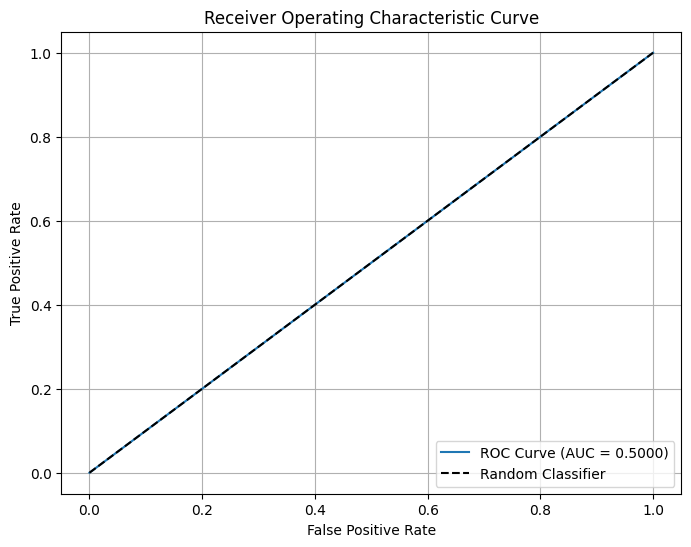

In [ ]:
 import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import StandardScaler

# Constants for file paths
FAKE_FEATURES_PATH = 'drive/MyDrive/SP_cup/features/standardized_fake.pkl'
REAL_FEATURES_PATH = 'drive/MyDrive/SP_cup/features/standardized_real.pkl'
CHECKPOINT_FILE = "drive/MyDrive/SP_cup/checkpoints/model_single_split.keras"

# Function to load features from a file
def load_features(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)

# Function to validate and extract features
def validate_and_extract(features, label):
    valid_features = []
    for entry in features:
        if isinstance(entry, dict) and 'features' in entry and 'image_name' in entry:
            valid_features.append(entry['features'])
    print(f"Extracted {len(valid_features)} features for label: {label}")
    return np.array(valid_features, dtype=np.float32)

# Load and preprocess data
def load_and_preprocess_data():
    print("Loading features...")
    fake_features = load_features(FAKE_FEATURES_PATH)
    real_features = load_features(REAL_FEATURES_PATH)

    # Validate and extract features
    X_fake = validate_and_extract(fake_features, label="Fake")
    X_real = validate_and_extract(real_features, label="Real")

    # Labels
    y_fake = np.ones(X_fake.shape[0])
    y_real = np.zeros(X_real.shape[0])

    # Combine data
    X_combined = np.vstack((X_fake, X_real))
    y_combined = np.hstack((y_fake, y_real))

    # Normalize features
    scaler = StandardScaler()
    X_combined = scaler.fit_transform(X_combined)

    return X_combined, y_combined, scaler

# Load model and evaluate using entire dataset
def evaluate_model():
    X_combined, y_combined, scaler = load_and_preprocess_data()

    # Use the entire dataset for validation
    X_val, y_val = X_combined, y_combined
    print("Using the entire dataset for validation.")

    # Print the size of the validation data
    print(f"Validation data size: {X_val.shape[0]} samples, Features: {X_val.shape[1]}")
    print(f"Validation labels size: {y_val.shape[0]} samples")

    # Load the trained model
    print("Loading trained model...")
    model = tf.keras.models.load_model(CHECKPOINT_FILE)

    # Predictions
    print("Making predictions on validation data...")
    y_pred_prob = model.predict(X_val, batch_size=64)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Metrics
    print("Validation Metrics:")
    print(classification_report(y_val, y_pred, target_names=['Real', 'Fake']))
    print("Confusion Matrix:")
    print(confusion_matrix(y_val, y_pred))

    # ROC-AUC Score
    auc_score = roc_auc_score(y_val, y_pred_prob)
    print(f"ROC-AUC Score: {auc_score:.4f}")

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.4f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Run evaluation using the entire dataset
evaluate_model()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

def check_folder_stats(folder_path):
    total_size = 0
    file_count = 0

    for dirpath, dirnames, filenames in os.walk(folder_path):
        for file in filenames:
            file_path = os.path.join(dirpath, file)
            total_size += os.path.getsize(file_path)
            file_count += 1

    return total_size, file_count

# Specify your folder path here
folder_path = 'drive/MyDrive/SP_cup/features/standardized_fake.pkl'

total_size, file_count = check_folder_stats(folder_path)

print(f"Total size: {total_size / (1024 * 1024):.2f} MB")
print(f"Total number of files: {file_count}")


Total size: 0.00 MB
Total number of files: 0


In [ ]:
import os
import torch
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler, TensorDataset
from sklearn.utils.class_weight import compute_class_weight
from concurrent.futures import ThreadPoolExecutor
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Set GPU memory limit to 11 GB
if torch.cuda.is_available():
    torch.cuda.set_per_process_memory_fraction(11 / torch.cuda.get_device_properties(0).total_memory)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths for real and fake images
real_path = 'drive/MyDrive/SP_cup/train-real'
fake_path = 'drive/MyDrive/SP_cup/fake'

# Checkpoint file path
checkpoint_path = 'drive/MyDrive/resnet_checkpoint.pth'

# Data transformation
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Function to load a single dataset folder in parallel
def load_images_parallel(dataset_path, label, description):
    dataset = datasets.ImageFolder(dataset_path, transform=data_transforms)
    images = torch.empty(len(dataset), 3, 224, 224)
    labels = torch.full((len(dataset),), label, dtype=torch.long)

    def load_sample(index):
        img, _ = dataset[index]
        images[index] = img

    with ThreadPoolExecutor() as executor:
        list(tqdm(executor.map(load_sample, range(len(dataset))), total=len(dataset), desc=description))

    return images, labels

# Load real dataset first, then fake dataset
print("Loading real images...")
real_images, real_labels = load_images_parallel(real_path, 0, "Loading real images")

print("Loading fake images...")
fake_images, fake_labels = load_images_parallel(fake_path, 1, "Loading fake images")

# Combine real and fake datasets
combined_images = torch.cat((real_images, fake_images))
combined_labels = torch.cat((real_labels, fake_labels))

# Calculate class weights for handling imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(combined_labels.numpy()), y=combined_labels.numpy())
sample_weights = [class_weights[label] for label in combined_labels.numpy()]

# Create a WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Create a DataLoader
train_dataset = TensorDataset(combined_images, combined_labels)
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, pin_memory=True, num_workers=8)

# Define the ResNet model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # Modify output layer for binary classification
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Enable AMP for faster training
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

# Function to save checkpoint
def save_checkpoint(state, filename=checkpoint_path):
    torch.save(state, filename)
    print(f"Checkpoint saved to {filename}")

# Function to load checkpoint
def load_checkpoint(filename=checkpoint_path):
    if os.path.exists(filename):
        print(f"Loading checkpoint from {filename}")
        return torch.load(filename, map_location=device)
    return None

# Load checkpoint if available
start_epoch = 0
checkpoint = load_checkpoint()
if checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resumed training from epoch {start_epoch}")

# Training loop
num_epochs = 10

for epoch in range(start_epoch, num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    print(f"Epoch {epoch + 1}/{num_epochs}")
    for images, labels in tqdm(train_loader, desc="Training batches", leave=False):
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        # Forward pass with AMP
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            outputs = model(images)
            loss = criterion(outputs, labels)

        # Backward pass and optimization with AMP
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Calculate statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total

    print(f"  Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # Save checkpoint after each epoch
    save_checkpoint({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': epoch_loss,
    })

print("Training completed.")


Loading real images...


Loading real images:   1%|          | 184/17090 [00:36<56:10,  5.02it/s]  


KeyboardInterrupt: 